Things that need to be named correctly for this to work

1. Change ``rootFolderPath`` to be correct for your system and no windows may need to worry about forward vs back slash
2. ``filepath.split('/')[7][0] `` is specific to the computer I ran this on and the "7" should probably change
3. The script will recursively search through all child directories of a root directory and process anything ending in "tracks.xml"
4. ``/5_pJRF010_pLG906_240_uM/mEos3.2_PALM/PALM05_tracks.xml`` is the correct end of the directory structure and the second-to-last directory includes experiment information
   1. "5" is irrelevant here but something must be included here in the folder names
   2. "pJRF010" is the name of the mNeonGreen-expressing plasmid
   3. "pLG906" is the name of the mEos3.2-expressing plasmid
   4. "240" is the IPTG concentration for the experiment in micromolar

In [112]:
import os

import pandas as pd

def add_protein_column(Condition, a):
    plasmid_name = Condition.split('_')[a]
    protein = plasmid_to_protein.get(plasmid_name, None)

    if (protein=='PerMn1')*(Condition.split('_')[3]=='0'):
        protein = protein + ' uninduced'
    
    if protein:
        return protein
    else:
        return None

# Find all *tracks.xml files in subdirectories
rootFolderPath = '/home/zach/Desktop/microscope_data/FtsB_tracking/'

n = 0

dates = []
filepaths = []
conditions = []
image_file = []
iptg=[]

for root, dirs, files in os.walk(rootFolderPath):
    for filename in files:
        if filename[-10:] == 'tracks.xml':
            filepath = os.path.join(root, filename)
            if filepath.split('/')[7][0] != '0': # exclude one experiment imaging sooner after preparing sample
                filepaths.append(filepath)
                dates.append(filepath.split('/')[6].split(' ')[0])
                conditions.append(filepath.split('/')[7][0:])
                image_file.append(filepath.split('/')[9].split('_')[0])
                iptg.append(filepath.split('/')[7].split('_')[3])
                
                n += 1

df = pd.DataFrame(data = {'Date':dates, 'Path':filepaths, 'Condition':conditions,'Image file':image_file,'IPTG': iptg}).sort_values(by=['Date', 'Condition', 'Image file'])

plasmid_to_protein = { 'pJRF004n1':'PerMn1',
                      'pLG906':'FtsBΔLQΔH',
                      'pZH904':'FtsBΔLQ',
                      'pJRF010':'Pf3'}

df['Protein1'] = df['Condition'].apply(add_protein_column, a = 1)
df['Protein2'] = df['Condition'].apply(add_protein_column, a = 2)
df['Tracks'] = [ [] for i in range(len(df)) ]

In [113]:
# Load in all track xml files from TrackMate analysis

import numpy as np
import matplotlib.pylab as plt
from os import path
from xml.dom import minidom
from IPython.display import clear_output

def import_track_xml(filepath):
  tracks = []
  file_data = minidom.parse(filepath)

  for track in file_data.getElementsByTagName("particle"):
    detections = track.getElementsByTagName("detection")
    numSpots = len(detections)
    track_xy = np.empty([numSpots, 2], dtype=float)
    for i in range(numSpots):
      track_xy[i][0] = detections[i].getAttribute("x")
      track_xy[i][1] = detections[i].getAttribute("y")

    # Add track if all points are at least 1000 nm (10 pixels) from edge of image
    if np.min([track_xy[:][0], track_xy[:][1], 25600 - track_xy[:][0], 25600 - track_xy[:][1]]) > 500:
        tracks.append(track_xy)

  return(tracks)

def add_tracks(filepath):
    global i
    clear_output(wait=True)
    i += 1
    print('Loading',filepath)
    print('File',i,'of',len(df))
    tracks = import_track_xml(filepath)
    print(len(tracks),'tracks loaded')
    return tracks

i = 0
df['Tracks'] = df['Path'].apply(add_tracks)

Loading /home/zach/Desktop/microscope_data/FtsB_tracking/231012 PALM PerM FtsB/5_pJRF010_pLG906_240_uM/mEos3.2_PALM/PALM05_tracks.xml
File 75 of 75
2239 tracks loaded


In [114]:
#@title Make image masks

from scipy.ndimage import gaussian_filter,maximum_filter
import scipy

def add_mask(spotMedians):
    global i
    clear_output(wait=True)
    i += 1
    
    print('Making masks for file',i,'of',len(df))

    maskImage = gaussian_filter(spotMedians, gaussian_sigma)
    maskImage = maskImage > threshold
    maskImage = maximum_filter(maskImage, size=maxFilterSize)
    maskImage[0:borderMask,:] = maskImage[:,0:borderMask] = maskImage[-borderMask:,:] = maskImage[:,-borderMask:] = 1
    
    return maskImage

gaussian_sigma =1.5 # pixels to blur
threshold = 2 # threshold of number of trajectories w/ median coordinate in pixel after blur
resolution = 100; # nm/pixel
maxFilterSize = 2;
borderMask = 5; # number of pixels to exclude on border

df['maskImage'] = [ np.zeros((256,256)) for i in range(len(df)) ]
df['spotMedians'] = [ np.zeros((256,256)) for i in range(len(df)) ]
spotMedians = np.zeros((len(files),256,256))

medIdx = df.columns.get_loc('spotMedians')

i = 0
for f in range(len(df)):
  i += 1
  clear_output(wait=True)
  print('Median spots for file',i,'of',len(df))
    
  for trajectory in df.iloc[f].Tracks:
    medCoordinate = np.int_(np.floor(np.median(trajectory,axis=0) / resolution))
    df.iloc[f,medIdx][medCoordinate[1],medCoordinate[0]] = df.iloc[f]['spotMedians'][medCoordinate[1],medCoordinate[0]] + 1

i = 0
df['maskImage'] = df['spotMedians'].apply(add_mask)


Making masks for file 75 of 75


In [115]:
# Calculate displacement data for all experiments on all days individually

def calculate_mean_square_displacement(file, minimum_trajectory_spots=2, maximum_trajectory_spots=21, mask_too_dense_spots=True, 
                                       maskImages=None, resolution=100, maximum_points_per_trajectory=10):
    global i
    clear_output(wait=True)
    i += 1
    print('Calculating msds for',i,'of',len(df))

    traj_lengths = np.array([len(trajectory) for trajectory in file])
    max_length = traj_lengths.max()

    if max_length > maximum_trajectory_spots:
        max_length = traj_lengths[traj_lengths <= maximum_trajectory_spots].max()

    sds = [[] for _ in range(1, max_length)]
    all_displacements = np.empty(0)
    
    for trajectory in file:
        
        if len(trajectory) >= minimum_trajectory_spots and len(trajectory) <= maximum_trajectory_spots:
            use_trajectory = 1
    
            if mask_too_dense_spots and maskImages is not None:
                medCoordinate = np.int_(np.floor(np.median(trajectory, axis=0) / resolution))
                if maskImages[i, medCoordinate[1], medCoordinate[0]]:
                    use_trajectory = 0
    
            if use_trajectory:
                maxJ = np.min([maximum_points_per_trajectory, len(trajectory) - 1])
                displacements = (trajectory[1:, :] - trajectory[0, :]) / 1e3
                all_displacements = np.sqrt(np.sum(((trajectory[1:, :] - trajectory[0:-1, :]) / 1e3) ** 2, axis=1))
    
                for j in range(maxJ):
                    traj_sds = np.sum(displacements ** 2, axis=1)
                    for t in range(len(traj_sds)):
                        sds[t].append(traj_sds[t])
                    displacements = displacements[1:,:]-displacements[0,:]

    mean_square_displacement = np.array([np.mean(x) for x in sds])
    error_bar = np.array([np.std(x)/np.sqrt(len(x)) for x in sds])
    measurement = np.array([len(x) for x in sds])

    return mean_square_displacement, error_bar, measurement, sds

i = 0
df[['msd', 'msd_error', 'msd_N', 'sds']] = df.apply(lambda row: calculate_mean_square_displacement(row.Tracks), axis=1, result_type="expand")

Calculating msds for 75 of 75


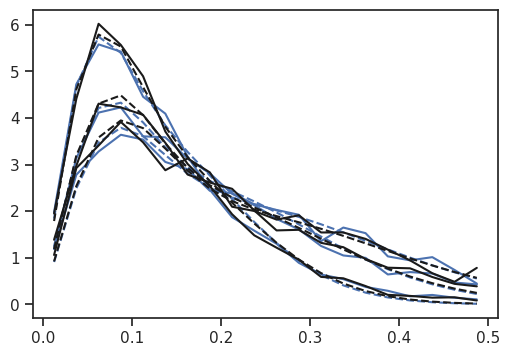

In [261]:
# calculate probability density for displacements P(r,t) and fit for all experiments on all days individually

from scipy import optimize
import scipy.stats as stats

# Function to fit MSD (Matsuoka 2009 via Spot-On paper)

# P(r,t) = ( r / ( 2*(D*t + s^2) ) ) * exp ( -r^2 / (4 * (D*t + s^2) ) )
# For effective 1D diffusion we will change 4 above to 2
# Additionally, return with rows divided by their sum

def normalized_1D_diffusion(rt, D, s):
    r, t = rt
    P = ( r / (2*D*t + 2*s**2) ) * np.exp( -r**2 / (4*D*t + 4*s**2))
    # P = ( r / (2 * D * t + 2*s**2) ) * np.exp( -r**2 / (4* D * t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P

def normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    r, t = rt
    # P = F1 * ( r / (np.sqrt(D1 * t + s**2)) ) * np.exp( -r**2 / (2*(D1 * t + s**2))) \
    #     + (1 - F1) * ( r / (np.sqrt(D2 * t + s**2)) ) * np.exp( -r**2 / (2*(D2 * t + s**2)))

    P = F1 * ( r / (2*D1*t + 2*s**2) ) * np.exp( -r**2 / (4*D1*t + 4*s**2)) \
        + (1 - F1) * ( r / (2*D2*t + 2*s**2) ) * np.exp( -r**2 / (4*D2*t + 4*s**2))

    P = F1 * ( r / (D1*t + 2*s**2) ) * np.exp( -r**2 / (2*D1*t + 4*s**2)) \
        + (1 - F1) * ( r / (D2*t + 2*s**2) ) * np.exp( -r**2 / (2*D2*t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P

max_fit_jump = 0.5 # max jump to consider in microns
bin_width = 0.025 # bin width in microns
max_fit_tau = 3 # max number of jumps to consider when fitting
dt = 0.033 # time between frames
use_kde = False
fit_two_populations = True

n_bins = np.floor(max_fit_jump/bin_width).astype(int)
bins = np.linspace(0., max_fit_jump, n_bins+1)

r = bins[1:] - bin_width/2
t = dt*(1 + np.arange(max_fit_tau))
rr, tt = np.meshgrid(r, t)
rt = (rr.ravel(), tt.ravel())

# First: add probability density to dataframe for each row from square displacements

plot_data = []

# arrays to be filled in
params = [None] * len(df)
pcov = [None] * len(df)

cs = 'rgbkmc'

pcs = {}
i = 0

for p in df.Proteins.unique():
    
    pcs[p] = cs[i]
    i += 1

for i in range(len(df)):

    plotme = np.random.random()

    plot_data.append(np.zeros([n_bins,max_fit_tau]))

    for j in range(max_fit_tau):

        j_data = np.sqrt(df.iloc[i].sds[j])

        if use_kde:
            density = stats.gaussian_kde(j_data)
            plot_data[i][:,j] = density(r)
        else:
            plot_data[i][:,j], _ = np.histogram(j_data,bins)

        # normalize separately for each tau
        plot_data[i][:,j] = plot_data[i][:,j]/plot_data[i][:,j].sum()

        if plotme < .05:
            plt.plot(r,plot_data[i][:,j]/bin_width,pcs[df.iloc[i].Proteins])

    # normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    
    # Fit data
    guess = (0.3, 0.05195) # guess D in microns^2/s and fit error, s, in microns

    if fit_two_populations:
        # bounds = ([0,0,0.2,0.051949],[1,0.2,np.inf,0.051951])
        bounds = ([0,0,0.2,0.0],[1,0.2,np.inf,np.inf])
        params[i], pcov[i] = optimize.curve_fit(normalized_two_pop_diffusion, rt, plot_data[i].T.ravel(),
                                        p0=[0.5, guess[0]/2, guess[0]*2, guess[1]], bounds=bounds)
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if plotme < .05:
                #params[i][3] = 0
                plt.plot(r,normalized_two_pop_diffusion(rt_plot,params[i][0],params[i][1],params[i][2],params[i][3])/bin_width,pcs[df.iloc[i].Proteins] + '--')
    else:
        params[i], pcov[i] = optimize.curve_fit(normalized_1D_diffusion, rt, plot_data[i].T.ravel(),
                                            p0=guess, bounds=(0,np.inf))
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if plotme < 0.05:
                plt.plot(r,normalized_1D_diffusion(rt_plot,params[i][0],params[i][1])/bin_width,pcs[df.iloc[i].Proteins] + '--')
                if j==0:
                    print(params[i])
            
plt.show()

0.02842156786427822


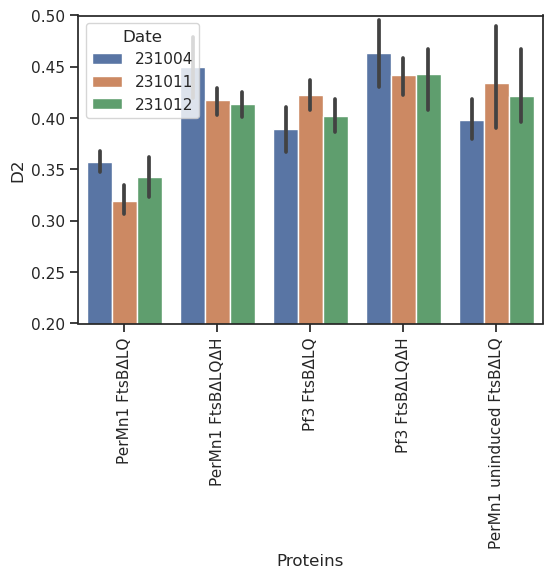

In [263]:
# Plot results for two population fit

import seaborn as sns

F1 = [ i[0] for i in params ]
D1 = [ i[1] for i in params ]
D2 = [ i[2] for i in params ]
s = [ i[3] for i in params ]

df['F1'] = F1
df['D1'] = D1
df['D2'] = D2
df['s'] = s
df['Proteins'] = df['Protein1'] + ' ' + df['Protein2']

sns.barplot(data = df, x = 'Proteins', y = 'D2', hue='Date', dodge=True)
plt.xticks(rotation=90)

print(df.s.median())
plt.ylim([0.2, 0.5])
plt.show()

231004 PerMn1 FtsBΔLQ [0.2761245  0.01448514 0.16251279 0.02672151]
231004 PerMn1 FtsBΔLQΔH [0.24738208 0.01163489 0.20652774 0.0303191 ]
231004 Pf3 FtsBΔLQ [0.24889163 0.0108613  0.17692768 0.02874152]
231004 Pf3 FtsBΔLQΔH [0.25020563 0.01005206 0.20556748 0.03158622]
231004 PerMn1 uninduced FtsBΔLQ [0.25413359 0.00757842 0.17938627 0.03165064]
231011 PerMn1 uninduced FtsBΔLQ [0.24954884 0.01176104 0.19356288 0.03127751]
231011 PerMn1 FtsBΔLQ [0.30095429 0.01075061 0.15082209 0.02946064]
231011 PerMn1 FtsBΔLQΔH [0.27218162 0.00847432 0.19077457 0.03066968]
231011 Pf3 FtsBΔLQ [0.26603183 0.0103213  0.19378889 0.03294435]
231011 Pf3 FtsBΔLQΔH [0.27646823 0.00513586 0.20075285 0.03635359]
231012 PerMn1 uninduced FtsBΔLQ [0.27683993 0.01227038 0.18872852 0.03172326]
231012 PerMn1 FtsBΔLQ [0.3059179  0.01131405 0.15604591 0.03058067]
231012 PerMn1 FtsBΔLQΔH [0.30312352 0.00837917 0.18856883 0.03247265]
231012 Pf3 FtsBΔLQ [0.2713435  0.00848369 0.17582864 0.03402129]
231012 Pf3 FtsBΔLQΔH [0

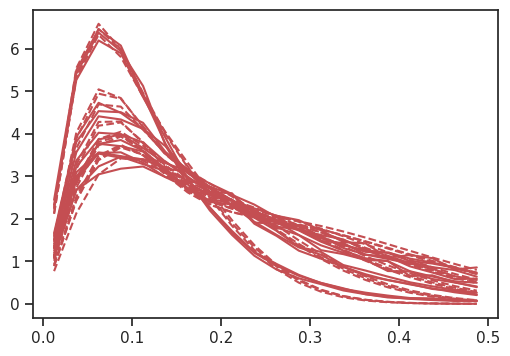

In [430]:
# Analyze data aggregated by day

day_df = pd.DataFrame({'Date' : [], 'Proteins' : [], 'sds' : []})

for d in df.Date.unique():
    for p in df.query('Date==@d').Proteins.unique():
        df2 = df.query('Date==@d & Proteins==@p')
        
        maxL = 0
        for s in df2.sds:
            maxL = max(maxL, len(s))

        sds = [ [] ] * maxL
        
        for s in df2.sds:
            for i in range(len(s)):
                sds[i] = sds[i] + s[i]

        day_df = pd.concat([day_df, pd.DataFrame({'Date' : d, 'Proteins' : p, 'sds' : [sds]})], ignore_index=True)

# calculate probability density for displacements P(r,t) and fit for all experiments on all days individually

from scipy import optimize
import scipy.stats as stats

# Function to fit MSD (Matsuoka 2009 via Spot-On paper)

# P(r,t) = ( r / ( 2*(D*t + s^2) ) ) * exp ( -r^2 / (4 * (D*t + s^2) ) )
# For effective 1D diffusion we will change 4 above to 2
# Additionally, return with rows divided by their sum

def normalized_1D_diffusion(rt, D, s):
    r, t = rt
    P = ( r / (2*D*t + 2*s**2) ) * np.exp( -r**2 / (4*D*t + 4*s**2))
    # P = ( r / (2 * D * t + 2*s**2) ) * np.exp( -r**2 / (4* D * t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P

def normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    r, t = rt

    P = F1 * ( r / (2*D1*t + 2*s**2) ) * np.exp( -r**2 / (4*D1*t + 4*s**2)) \
        + (1 - F1) * ( r / (2*D2*t + 2*s**2) ) * np.exp( -r**2 / (4*D2*t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P

max_fit_jump = 0.5 # max jump to consider in microns
bin_width = 0.025 # bin width in microns
max_fit_tau = 5 # max number of jumps to consider when fitting
dt = 0.033 # time between frames
use_kde = False
fit_two_populations = True

plot_rand = 1 # change to less than 1 to only have some probability of plotting each line
plot_lags = [0,1,2,3,4] # list of what lags to plot vs number used to fit above
plot_proteins = ['PerMn1 FtsBΔLQ']

n_bins = np.floor(max_fit_jump/bin_width).astype(int)
bins = np.linspace(0., max_fit_jump, n_bins+1)

r = bins[1:] - bin_width/2
t = dt*(1 + np.arange(max_fit_tau))
rr, tt = np.meshgrid(r, t)
rt = (rr.ravel(), tt.ravel())

# First: add probability density to dataframe for each row from square displacements

plot_data = []

# arrays to be filled in
params = [None] * len(day_df)
pcov = [None] * len(day_df)

cs = 'rgbkmc'

pcs = {}
i = 0

for p in day_df.Proteins.unique():
    
    pcs[p] = cs[i]
    i += 1

for i in range(len(day_df)):

    plotme = np.random.random()

    plot_data.append(np.zeros([n_bins,max_fit_tau]))

    for j in range(max_fit_tau):

        j_data = np.sqrt(day_df.iloc[i].sds[j])

        if use_kde:
            density = stats.gaussian_kde(j_data)
            plot_data[i][:,j] = density(r)
        else:
            plot_data[i][:,j], _ = np.histogram(j_data,bins)

        # normalize separately for each tau
        plot_data[i][:,j] = plot_data[i][:,j]/plot_data[i][:,j].sum()

        if (plotme < plot_rand) & (j in plot_lags) & (day_df.iloc[i].Proteins in plot_proteins):
            plt.plot(r,plot_data[i][:,j]/bin_width,pcs[day_df.iloc[i].Proteins])

    # normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    
    # Fit data
    guess = (0.3, 0.05195) # guess D in microns^2/s and fit error, s, in microns

    if fit_two_populations:
        # bounds = ([0,0,0.2,0.051949],[1,0.2,np.inf,0.051951])
        bounds = ([0,0,0.05,0.0],[1,0.2,np.inf,np.inf])
        params[i], pcov[i] = optimize.curve_fit(normalized_two_pop_diffusion, rt, plot_data[i].T.ravel(),
                                        p0=[0.5, guess[0]/2, guess[0]*2, guess[1]], bounds=bounds)
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if (plotme < plot_rand)  & (j in plot_lags) & (day_df.iloc[i].Proteins in plot_proteins):
                #params[i][3] = 0
                plt.plot(r,normalized_two_pop_diffusion(rt_plot,params[i][0],params[i][1],params[i][2],params[i][3])/bin_width,pcs[day_df.iloc[i].Proteins] + '--')
            if j==1:
                print(day_df.iloc[i].Date,day_df.iloc[i].Proteins,params[i])
    else:
        params[i], pcov[i] = optimize.curve_fit(normalized_1D_diffusion, rt, plot_data[i].T.ravel(),
                                            p0=guess, bounds=(0,np.inf))
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if (plotme < plot_rand)  & (j in plot_lags) & (day_df.iloc[i].Proteins in plot_proteins):
                plt.plot(r,normalized_1D_diffusion(rt_plot,params[i][0],params[i][1])/bin_width,pcs[day_df.iloc[i].Proteins] + '--')
            if j==1:
                print(params[i])
            
plt.show()

# Compare to mNeonGreen tracking

# Compare to out of focus tracking

0.03158622445503929


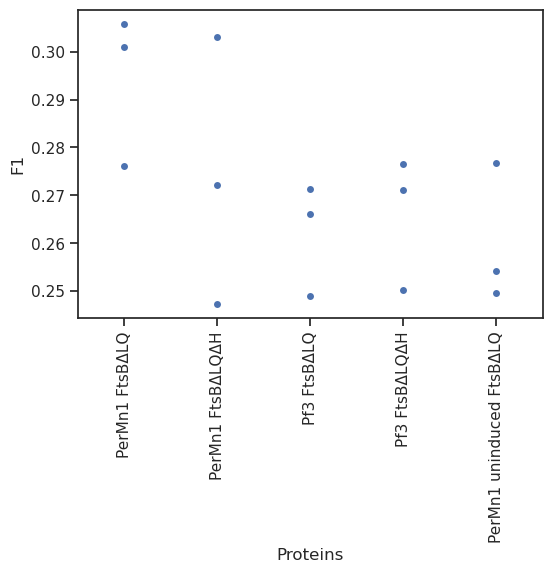

In [435]:
# Plot results for two population fit

import seaborn as sns

F1 = [ i[0] for i in params ]
D1 = [ i[1] for i in params ]
D2 = [ i[2] for i in params ]
s = [ i[3] for i in params ]

day_df['F1'] = F1
day_df['D1'] = D1
day_df['D2'] = D2
day_df['s'] = s

sns.swarmplot(data = day_df, x = 'Proteins', y = 'F1', dodge=False)
plt.xticks(rotation=90)

print(day_df.s.median())
# plt.ylim([0.2, 0.5])
plt.show()

In [414]:
# Make all data into form that saspt can handle combining all movies from one day together

dates = df.Date.unique()

filepaths = []
conditions = []

for d in dates:
    ps = df.query('Date==@d').Proteins.unique()

    for p in ps:
        conditions.append(p)
        filepath = '_'.join([d,p.replace(' ','_')]) + '.csv'
        filepaths.append('/home/zach/Desktop/microscope_data/FtsB_tracking/saspt/' + filepath)

        tracks = sum(df.query('Date==@d & Proteins==@p').Tracks, [])

        N = 0 # number of localizations
        for track in tracks:
            N += track.shape[0]
        
        frames = np.zeros(N)
        ys = np.zeros(N)
        xs = np.zeros(N)
        trajectories = np.zeros(N)
        
        idx = 0
        
        for i in range(len(tracks)):
            for j in range(len(tracks[i])):
                xs[idx] = tracks[i][j][0]/100
                ys[idx] = tracks[i][j][1]/100
                trajectories[idx] = i
                frames[idx] = j
                idx += 1

        saspt_df = pd.DataFrame({'frame' : frames, 'y' : ys, 'x' : xs, 'trajectory' : trajectories})
        saspt_df.to_csv('/home/zach/Desktop/microscope_data/FtsB_tracking/saspt/' + filepath)

experiment_conditions = pd.DataFrame({'filepath' : filepaths, 'condition' : conditions})
experiment_conditions.to_csv('/home/zach/Desktop/microscope_data/FtsB_tracking/saspt/experiment_conditions.csv')

In [412]:
sum([len(t) for t in ts])

15150

In [391]:


saspt_df = pd.DataFrame({'frame' : frames, 'y' : ys, 'x' : xs, 'trajectory' : trajectories})
saspt_df.to_csv('/home/zach/Desktop/microscope_data/FtsB_tracking/saspt/test_data.csv')

'Pf3 FtsBΔLQΔH'

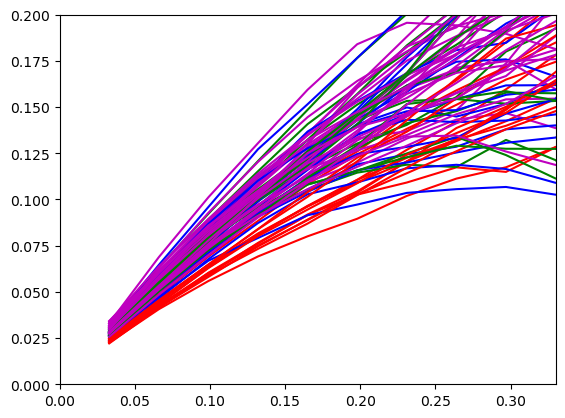

In [184]:
# test plotting various MSDs

t = 0.033*np.arange(1,21)

plasmid_to_protein = { 'pJRF004n1':'PerMn1',
                      'pLG906':'FtsBΔLQΔH',
                      'pZH904':'FtsBΔLQ',
                      'pJRF010':'Pf3'}

for i in range(75):
    p1 = df.iloc[i].Protein1
    p2 = df.iloc[i].Protein2
    iptg = df.iloc[i].Condition.split('_')[3]
    condition = p1 + ' ' + p2

    c = ''

    # if (condition == 'PerMn1 FtsBΔLQ')*(iptg == '100'):
    #     if df.iloc[i].Date == '231004':
    #         c = 'r'
    #     if df.iloc[i].Date == '231011':
    #         c = 'g'
    #     if df.iloc[i].Date == '231012':
    #         c = 'b'
    
    if (condition == 'PerMn1 FtsBΔLQ')*(iptg == '100'): # PerMn1 expression induced
        c = 'r'
    if (condition == 'PerMn1 FtsBΔLQ')*(iptg == '0'): # PerMn1 expression not induced
        c = 'b'
    if condition == 'PerMn1 FtsBΔLQΔH': # FtsB without PerM-binding helix
        c = 'g'
    if condition[0:3] == 'Pf3': # FtsB cannot bind Pf3 coat protein helix
        c = 'm'
        
    y = df.iloc[i].msd[0]

    if len(c):
        plt.plot(t[0:len(y)],y,c)

plt.ylim([0,0.2])
plt.xlim([0,0.33])
condition

In [94]:
import seaborn as sns
import random

sns.reset_defaults()
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("ticks")


# Sample data and parameters
max_display_frames = 10
max_display_time = 0.033 * max_display_frames
linestyle = '-'

# Create a color mapping for unique file names
unique_conditions = df['Condition'].unique()
color_mapping = {name: sns.color_palette("Set1")[i] for i, condition in enumerate(unique_conditions)}

legend_labels = []  # Create an empty list to store unique legend labels

for i in range(75):
    x = 0.033 * (1 + np.arange(len(df.iloc[i].msd[0]))
    
    # Get the color based on the file name
    color = color_mapping[df['Condition']]
    
    label = df['Condition']
    
    plt.errorbar(x[x <= max_display_time],
                 df.iloc[i].msd[0][x <= max_display_time],
                 yerr=error_bars[i][0][x <= max_display_time],
                 linestyle=linestyle,
                 color=color)
    
    # Check if the label is unique, and add it to the legend_labels list
    if label not in legend_labels:
        legend_labels.append(label)

# Create a custom legend with matching colors
legend_handles = [plt.Line2D([], [], color=color_mapping[label], label=label) for label in legend_labels]
plt.legend(handles=legend_handles)


plt.xlabel('time (s)')
plt.ylabel('Mean squared displacement (um^2)')
plt.ylim([0, 0.4])
plt.show()
sns.despine(top=True, right=True)

NameError: name 'file_names' is not defined

In [250]:
#@title plot histograms of all distances jumped between single frames in trajectories
import scipy.stats as stats

bins = np.linspace(0, 0.5, 25)
bw = bins[1]-bins[0]
plot_bins = bins[1:] - bw/2

cs = 'rgbkmc'

for i in range(len(files)):

    for j in [3]:

        j_data = np.sqrt(square_displacements[i][j])

        density = stats.gaussian_kde(j_data)
        density = density(plot_bins)
        plt.plot(plot_bins,density/(bw*density.sum()),cs[i],label=str(j*33) + ' ms')
        
        # density, bins = np.histogram(j_data,bins)
        # plt.plot(plot_bins,density/(bw*density.sum()),cs[i]+'--',label=str(j*33) + ' ms')
        

# for i in range(len(files)):
#   plt.hist(all_displacements[i], bins, alpha=0.5, label=file_names[i][:-4],density=True)

plt.legend()
plt.show()

IndexError: string index out of range

In [14]:
# make tidy dataframe with all displacement data

import pandas as pd

df = []

# for i in range(len(mean_square_displacements)):
for i in range(len(strains)):

  l = len(mean_square_displacements[i])

  t = dt * (1 + np.arange(l))

  for j in range(l):
    df.append([strains[i],t[j],mean_square_displacements[i][j]])


df = pd.DataFrame(df,columns=['Strain','Lag time (ms)','MSD'])

/tmp/ipykernel_2674328/564692127.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='Lag time (ms)', y='MSD', style='Strain',estimator='median',errorbar=None,palette=sns.color_palette("dark:#5A9_r", as_cmap=True))


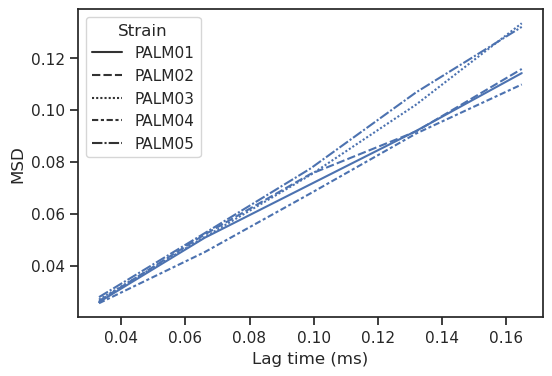

In [15]:
import seaborn as sns

sns.lineplot(data=df, x='Lag time (ms)', y='MSD', style='Strain',estimator='median',errorbar=None,palette=sns.color_palette("dark:#5A9_r", as_cmap=True))
# plt.xlim([0,0.5])
# plt.ylim([0,0.15])
plt.show()